In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import imageio
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as func
import torchvision.transforms as transforms
import torchvision
import matplotlib
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from scipy import interpolate
from torch.autograd import Variable
import resampling
matplotlib.style.use('ggplot')

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [196]:
def data_loader(number):
    if number == -1:
        x = torch.tensor(np.array([[0.01, 0.09], [0.09, 0.01], [0.01, 0.01], [0.09, 0.09], 
                           [0.91, 0.99], [0.99, 0.91], [0.91, 0.91], [0.99, 0.99],
                           [0.41, 0.49], [0.49, 0.41], [0.41, 0.41], [0.49, 0.49],
                           [0.01, 0.99], [0.09, 0.91], [0.01, 0.91], [0.09, 0.99]]), requires_grad=True)
        w = torch.ones(16, requires_grad=True) / 16
        return x, w
        
    np.random.seed(0)
    z = np.random.uniform(1, number, size=100)
    z = (number * np.exp(z - z.mean()) / (np.exp(z - z.mean())).sum()).astype(int)
    z[-1] += (number - z.sum())
    z = z[z>0]
    X = np.zeros((0, 2))
    w = np.zeros((0))
    for i in range(len(z)):
        p = np.random.uniform(0, 1, size=2)
        centers = p + np.array([[0.04 * np.random.randn(), 0.04 * np.random.randn()] for j in range(z[i])])
        centers = np.abs(centers)
        centers[centers>1] = 0.99
        weight = np.random.uniform(size=z[i])
        X = np.vstack((X, centers))
        w = np.hstack((w, weight))
    w /= w.sum()
    indxs = torch.randperm(len(X))
    X = X[indxs]
    return torch.tensor(X, requires_grad=True).double(), torch.tensor(w, requires_grad=True).double()

In [207]:
class SubSampler(nn.Module):
    def __init__(self, number, sub_number, debug=False, resamp_alpha=0.5, tau=1e-3):
        super(SubSampler, self).__init__()
        self.resamp_alpha = resamp_alpha
        self.tau = tau
        self.debug = debug
        self.number = number
        self.sub_number = sub_number
        torch.manual_seed(0)
        self.att = torch.randn(number, sub_number)
        self.y = torch.rand(sub_number, 2, requires_grad=True).double()
        self.v = torch.rand(sub_number, requires_grad=True).double()

    def init_centroids1(self, x, w, N_output):
        np.random.seed(0)
        torch.manual_seed(0)
        _, max_weight = torch.max(w)
        y = torch.tensor(x[max_weight], requires_grad=True)
        for i in range(N_output-1):
            d = torch.cdist(x, y, p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary')
            d_nearest, _ = torch.min(d, axis=1)
            next_idx = np.random.choice(np.arange(len(d_nearest)), size=1, p=d_nearest**2 / (d_nearest**2).sum())
            next_idx = torch.tensor(next_idx).long()
            y = torch.cat((y, x[next_idx]), dim=0)
        return y

    def init_centroids(self, x, w, N_output):
        np.random.seed(0)
        torch.manual_seed(0)
        indices = torch.topk(w, N_output)
        _, indices = torch.topk(w, self.sub_number)
        y = x[indices]
        return y

    def reset_params(self):
        torch.manual_seed(0)
        torch.nn.init.uniform_(self.y, a=0, b=1)

    def distances(self, x, y):
        D = torch.cdist(x, y, p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary')
        return D

    def attention(self, d):
        return torch.softmax(-d**2 / self.tau, axis=1)

    def forward(self, x, w, y=None):
        x = x.double()
        if y is None:
            self.y = self.init_centroids(x, w, self.sub_number)
        if self.debug:
            print(x[0], self.y[0])
        dist = self.distances(x, self.y)
        self.att = self.attention(dist)
        self.att = self.att.permute(1, 0)
        if self.debug:
            print(self.att.shape, torch.unsqueeze(w, 1).shape)
        self.y = torch.matmul(self.att, (x * torch.unsqueeze(w, 1))) / torch.matmul(self.att, torch.unsqueeze(w, 1))
        self.v = torch.matmul(self.att, torch.unsqueeze(w, 1)) / torch.sum(self.att, axis=1)
        return self.y, self.v

    def repulsion(self):
        return torch.mean(self.distances(torch.clamp(self.y, 0, 1), torch.clamp(self.y, 0, 1))**2)

In [208]:
N_input = 64
N_output = 8
x, w = data_loader(N_input)
model = SubSampler(N_input, N_output, debug=False).double()
model.train()
criterion = nn.L1Loss()
epochs = 1000
result = np.zeros((epochs))
y, v = model(x, w)
for i in range(epochs):
    y_old = y
    y, v = model(x, w, y)
    loss1 = criterion(y_old, y)
    loss2 = model.repulsion()
    loss = loss1 + 0*loss2
    result[i] = loss

tensor([[0.9198, 0.6628],
        [0.2086, 0.3764],
        [0.8923, 0.7428],
        [0.5162, 0.0627],
        [0.9498, 0.9565],
        [0.9284, 0.0906],
        [0.9856, 0.8809],
        [0.6986, 0.2736]], dtype=torch.float64, grad_fn=<DivBackward0>)

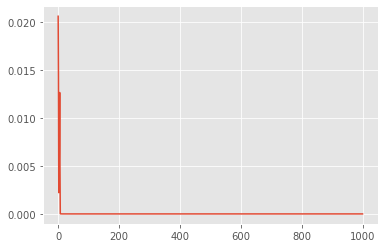

In [209]:
plt.plot(result)
model.y

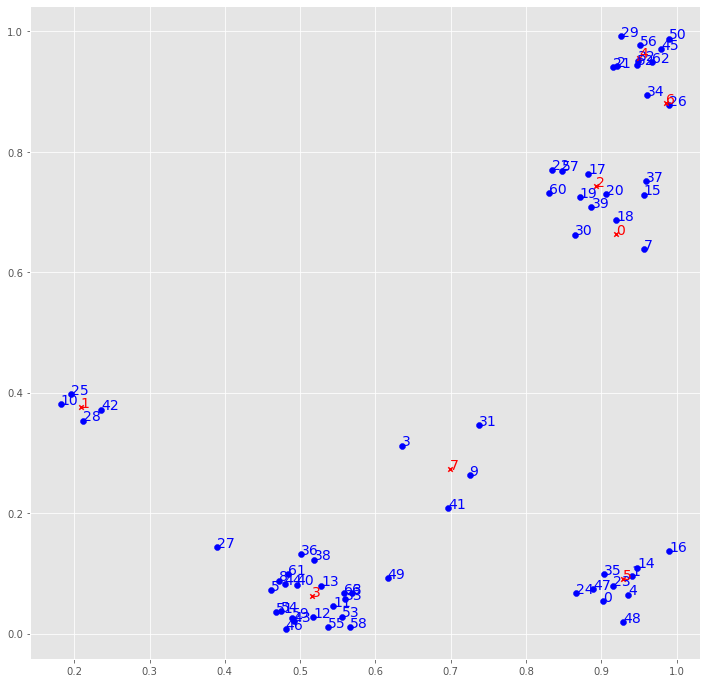

In [210]:
plt.figure(figsize=(12, 12))
#plt.scatter(x.detach().numpy()[:, 0], x.detach().numpy()[:, 1], color='blue')
for i in range(len(x)):
    plt.annotate(str(i), (x[i, 0], x[i, 1]), color='blue', fontsize=14)
    plt.scatter(x[i, 0].detach(), x[i, 1].detach(), color='blue')
for j in range(len(y)):
    plt.annotate(str(j), (y[j, 0], y[j, 1]), color='red', fontsize=14)
    plt.scatter(y[j, 0].detach(), y[j, 1].detach(), marker='x', s=20, color='red')
#plt.scatter(model.y.detach().numpy()[:, 0], model.y.detach().numpy()[:, 1], marker='x', s=20, color='red')

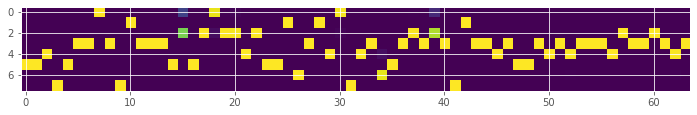

In [211]:
plt.figure(figsize=(12, 4))
plt.imshow(model.att.detach().numpy())

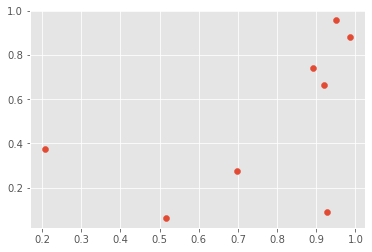

In [212]:
plt.scatter(model.y[:, 0].detach(), model.y[:, 1].detach())

In [213]:
y[0, 0].backward(retain_graph=True)
x.grad, w.grad

(tensor([[-2.9162e-82,  1.4504e-82],
         [-1.4209e-82,  7.0665e-83],
         [ 1.5929e-09,  1.0761e-08],
         [ 9.1526e-56,  1.7036e-55],
         [-3.5916e-83,  1.7862e-83],
         [ 2.6320e-67,  7.7336e-68],
         [ 2.0445e-67,  6.0073e-68],
         [ 5.9332e-01,  2.4024e-01],
         [ 4.2779e-68,  1.2570e-68],
         [ 1.3669e-55,  2.5443e-55],
         [ 9.0197e-96, -1.1613e-95],
         [ 1.7620e-67,  5.1773e-68],
         [ 3.5443e-68,  1.0414e-68],
         [ 2.4274e-67,  7.1324e-68],
         [-2.8930e-82,  1.4388e-82],
         [ 2.3520e-01, -6.6510e-01],
         [-2.5875e-82,  1.2868e-82],
         [-2.6826e-02,  9.4554e-04],
         [ 3.0422e-01,  9.3788e-02],
         [-4.0337e-03,  4.7910e-04],
         [-2.8610e-02, -2.9075e-03],
         [ 1.5293e-09,  3.7153e-09],
         [-5.8487e-02,  2.0612e-03],
         [-1.6612e-82,  8.2618e-83],
         [-2.5192e-83, -7.7332e-84],
         [ 3.2571e-95, -4.1938e-95],
         [-8.4125e-07, -5.4449e-06],
 